## Generating sequence with a recurring word

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import os
import sys
sys.path.append(os.getcwd())
from RNN_util import *

def set_seed(seed=42):
    """Fix random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
# Example usage:
set_seed(1)  # pick any integer seed you like
# Data preparation
sequence = 'E'
for _ in range(0,1000):
    sequence = sequence + 'ABCD' + 'E'*np.random.randint(0,20)
print(sequence[:100])

EABCDEEEEEABCDEEEEEEEEEEEABCDEEEEEEEEEEEEABCDEEEEEEEEABCDEEEEEEEEEABCDEEEEEEEEEEEABCDEEEEEABCDEEEEEE


In [2]:
# Create a dictionary to convert characters to integers
char_to_int = {char: i for i, char in enumerate('ABCDE')}
# Create a dictionary to convert integers to characters
int_to_char = {i: char for i, char in enumerate('ABCDE')}

# Model parameters
hidden_size = 12
input_size = len(char_to_int)
output_size = len(char_to_int)

# RNN Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [3]:
# Model parameters
hidden_size = 12
input_size = len(char_to_int)
output_size = len(char_to_int)
rnn = RNN(input_size, hidden_size, output_size) # 1 is transfer
rnn, hidden_states, hidden_seq,  acc_record, loss_record, iter_record = train_rnn(rnn, sequence,input_size,char_to_int, int_to_char, n_iters = 400)

Iteration 100 loss: 0.49395515441894533 acc: 0.83
Iteration 200 loss: 0.31294157028198244 acc: 0.92
Iteration 300 loss: 0.30049041748046873 acc: 0.925
Iteration 400 loss: 0.3104118919372559 acc: 0.91


## Visualize the prediction accuracy of this RNN during training

Text(0, 0.5, 'prediction accuracy')

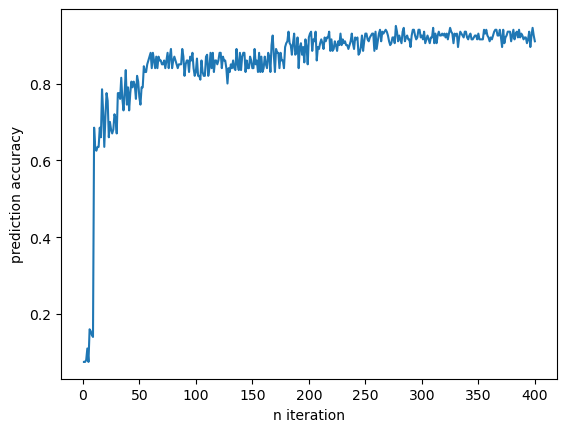

In [4]:
import matplotlib.pyplot as plt
plt.plot(iter_record, acc_record)
plt.xlabel('n iteration')
plt.ylabel('prediction accuracy')

## Forward generate the subsequent character prediction given the input character being A

In [5]:
# test one example
hidden = rnn.initHidden()
input_char = 'A'
for i in range(6):
    input_tensor = torch.nn.functional.one_hot(torch.tensor([char_to_int[input_char]], dtype=torch.long), num_classes=input_size).type(torch.float)
    # perturbation here 
    output, hidden = rnn(input_tensor, hidden)
    predict_char = int_to_char[output.argmax(1).item()]
    print('previous char ', input_char,' prediction char ', int_to_char[output.argmax(1).item()])
    input_char = predict_char

previous char  A  prediction char  B
previous char  B  prediction char  C
previous char  C  prediction char  D
previous char  D  prediction char  E
previous char  E  prediction char  E
previous char  E  prediction char  E


## Cued recall: test across a number of runs, if the network can consistently generate BCD following A


In [6]:
correct = False 
nABCD = 0
n_run = 1000
recall_p = np.zeros(shape = (3,n_run)) # evaluate the recall probability of BCD
for j in range(0, n_run):
    hidden = rnn.initHidden() # if you don't initialize, the same mistake will be repeated. because the hidden state is initialized from an incorrect recall session 
    input_char = 'A'
    char = 'A'
    for i in range(6):
        input_tensor = torch.nn.functional.one_hot(torch.tensor([char_to_int[input_char]], dtype=torch.long), num_classes=input_size).type(torch.float)
        output, hidden = rnn(input_tensor, hidden)
        predict_char = int_to_char[output.argmax(1).item()]
        input_char = predict_char
        char = char + predict_char
        if i <3:
            if predict_char == list('ABCD')[i+1]:
                recall_p[i,j] = 1
        if char == 'ABCD':
            nABCD = nABCD + 1

n_somethingelse = n_run - nABCD

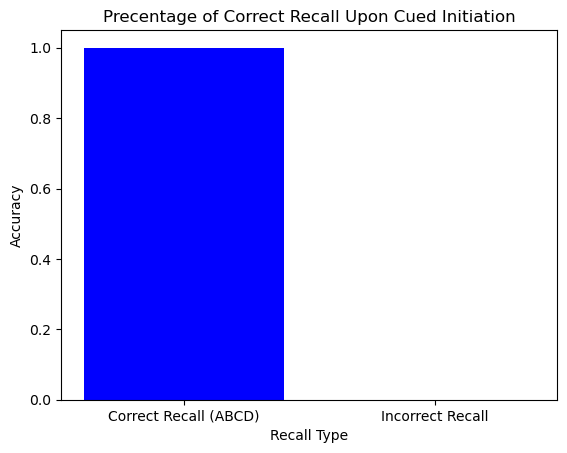

In [7]:
categories = ['Correct Recall (ABCD)', 'Incorrect Recall']
values = [nABCD/n_run, n_somethingelse/n_run]

plt.bar(categories, values, color=['blue', 'green'])
plt.title('Precentage of Correct Recall Upon Cued Initiation')
plt.xlabel('Recall Type')
plt.ylabel('Accuracy')
plt.xticks(categories)
plt.show()

# Visualize raw hidden unit activities

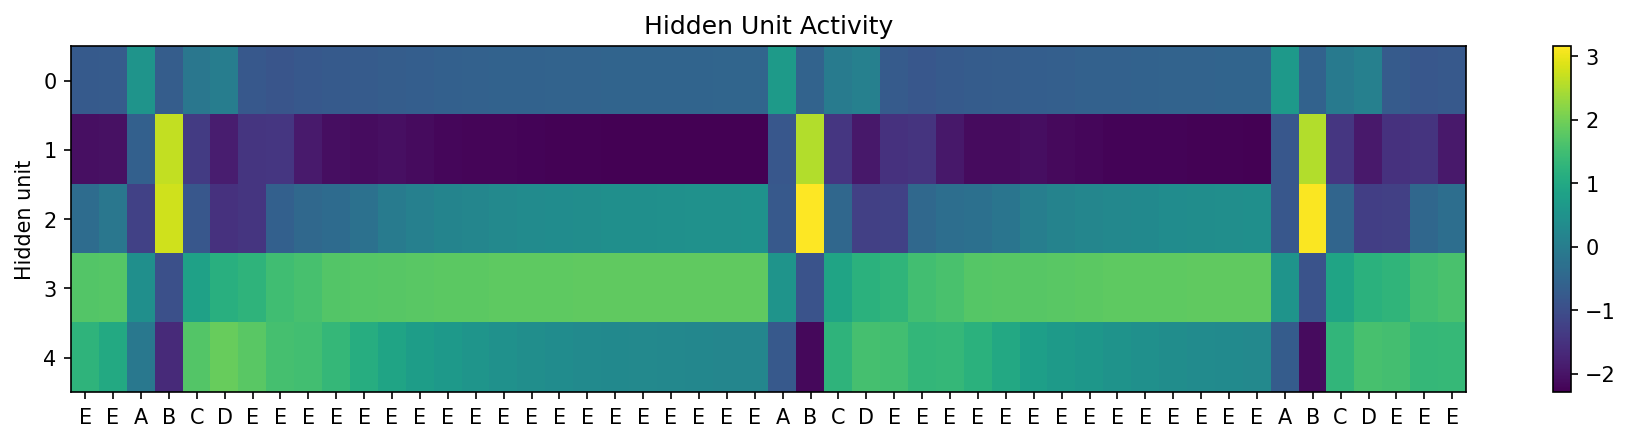

In [8]:
import matplotlib.pyplot as plt
hidden_states = np.array(hidden_states)
hidden_unit_activity = hidden_states[:, 0, :].T
plt.figure(figsize=(15, 3), dpi = 150)
plt.imshow(hidden_unit_activity[:5,10:60], aspect='auto', interpolation='nearest')
plt.colorbar()
plt.ylabel('Hidden unit')
plt.xticks(range(0, len(hidden_seq[10:60])),list(hidden_seq[10:60]))
plt.title('Hidden Unit Activity')
plt.show()

# Cluster the hidden unit activity individually

In [9]:
# convert hidden unit activity on a continous time scale to symbolic 
from sklearn.cluster import KMeans
import numpy as np

n_neurons = 12
num_bins = 5 # 5 clusters for each hidden units for now

cluster_center_record = np.zeros([n_neurons, num_bins]) # record the cluster center for each neuron
symbolic_hidden_activity = []
for i in range(0, hidden_unit_activity.shape[0]):
    data = hidden_unit_activity[i,:].reshape([-1,1]) 
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=num_bins, random_state=0).fit(data)
    # Assign each data point to the nearest cluster center (bin)
    binned_data = kmeans.predict(data)
    symbolic_hidden_activity.append(binned_data)
    cluster_center_record[i,:] = kmeans.cluster_centers_[:,0]
    # Optional: Replace each data point with the centroid of its bin
    # centroids = kmeans.cluster_centers_
    # discretized_data = centroids[binned_data]

# Assign individual neuron's activity to their closest cluster centriod

In [10]:
symbolic_hidden_activity = np.array(symbolic_hidden_activity) # each label in each neuron is independent

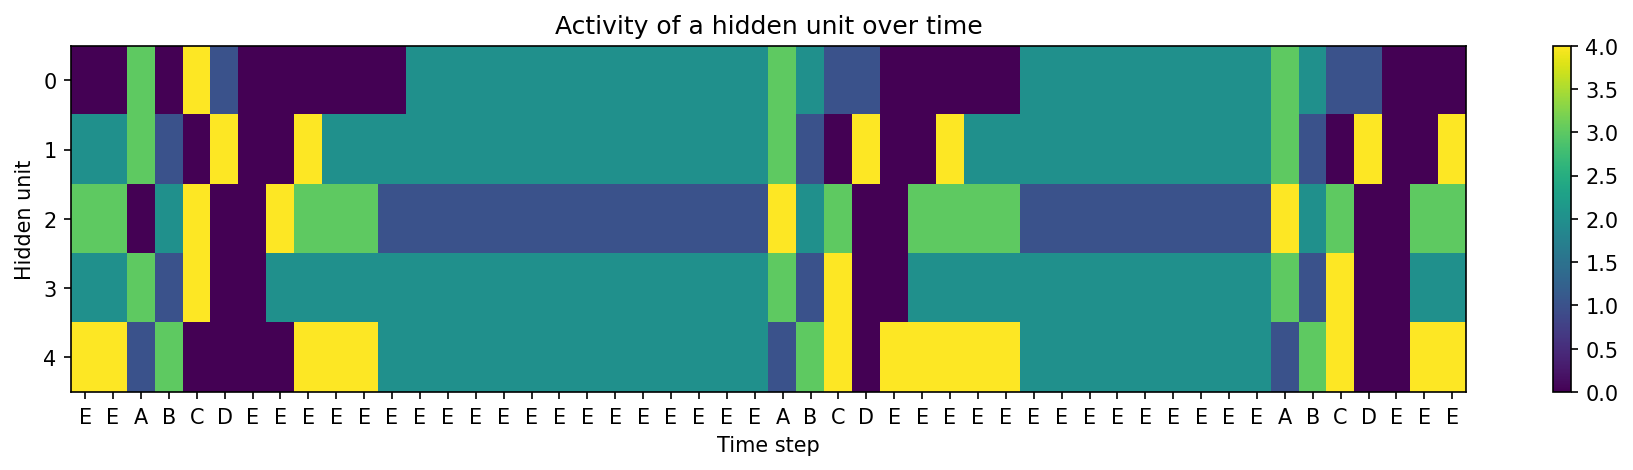

In [11]:
plt.figure(figsize=(15, 3), dpi = 150)
plt.imshow(symbolic_hidden_activity[:5,10:60], aspect='auto', interpolation='nearest')
plt.colorbar()
plt.xlabel('Time step')
plt.ylabel('Hidden unit')
plt.xticks(range(0, len(hidden_seq[10:60])),list(hidden_seq[10:60]))
plt.title('Activity of a hidden unit over time')
plt.show()

## Predict input based on hidden state activity and the previous hidden state

In [12]:
from collections import Counter
state_trajectory = []
for i in range(0,symbolic_hidden_activity.shape[1]):
    state = ''.join(str(num) for num in symbolic_hidden_activity[:,i])
    state_trajectory.append(state)
vocab = Counter(state_trajectory)

In [13]:
class LookupTable:
    """A lookup table to store the input unit correspond to RNN's internal hidden state"""
    def __init__(self):
        self.mapping = {}

    def train(self, input_symbols, output_symbols):
        self.mapping[input_symbols] = output_symbols

    def predict(self, input_symbol):
        return self.mapping.get(input_symbol, None)


In [14]:
predictor = LookupTable()
# train the predictor on a subset of the hidden data
train_l = 100
# Train
for state_symbol, input_symbol in zip(state_trajectory[:train_l],hidden_seq[:train_l]):
    predictor.train(state_symbol, input_symbol)

In [15]:
predictor.mapping

{'133324004443': 'D',
 '204040004440': 'E',
 '330322411312': 'A',
 '012111140221': 'B',
 '430403234140': 'C',
 '140000110043': 'D',
 '000000000044': 'E',
 '004000300000': 'E',
 '044202000404': 'E',
 '023202304404': 'E',
 '023242304014': 'E',
 '023242322014': 'E',
 '330310413332': 'A',
 '012131142221': 'B',
 '404403232140': 'C',
 '140000114043': 'D',
 '000000020004': 'E',
 '004200300000': 'E',
 '043242004404': 'E',
 '023242304404': 'E',
 '021222322014': 'E',
 '221222322014': 'E',
 '221222321014': 'E',
 '334310403332': 'A',
 '212131141221': 'B',
 '103443231100': 'C',
 '000040020004': 'E',
 '003240304000': 'E',
 '023242302414': 'E',
 '212131142221': 'B',
 '104443232100': 'C',
 '334310413332': 'A',
 '104403232100': 'C',
 '003240300000': 'E'}

In [16]:
# test the predictor on another subset of the hidden neural activity 
# Predict
acc = 0
prediction_record = {}
prediction_record['A'] = np.zeros([100])
prediction_record['B'] = np.zeros([100])
prediction_record['C'] = np.zeros([100])
prediction_record['D'] = np.zeros([100])
prediction_record['E'] = np.zeros([100])
i=0

for state_symbol, input_symbol in zip(state_trajectory[train_l:],hidden_seq[train_l:]):
    predicted_output = predictor.predict(state_symbol)
    acc = acc + int(predicted_output == input_symbol) 
    if predicted_output!=None:
        prediction_record[predicted_output][i] = 1
    i = i + 1    
    #print("Predicted output for input symbol '{}': {}".format(input_symbol, predicted_output))
acc = acc/len(hidden_seq[train_l:])
print('prediction accuracy is {}: '.format(acc))
# sometimes A is not predicted, this is because look up table has not seen the state before 

prediction accuracy is 0.92: 


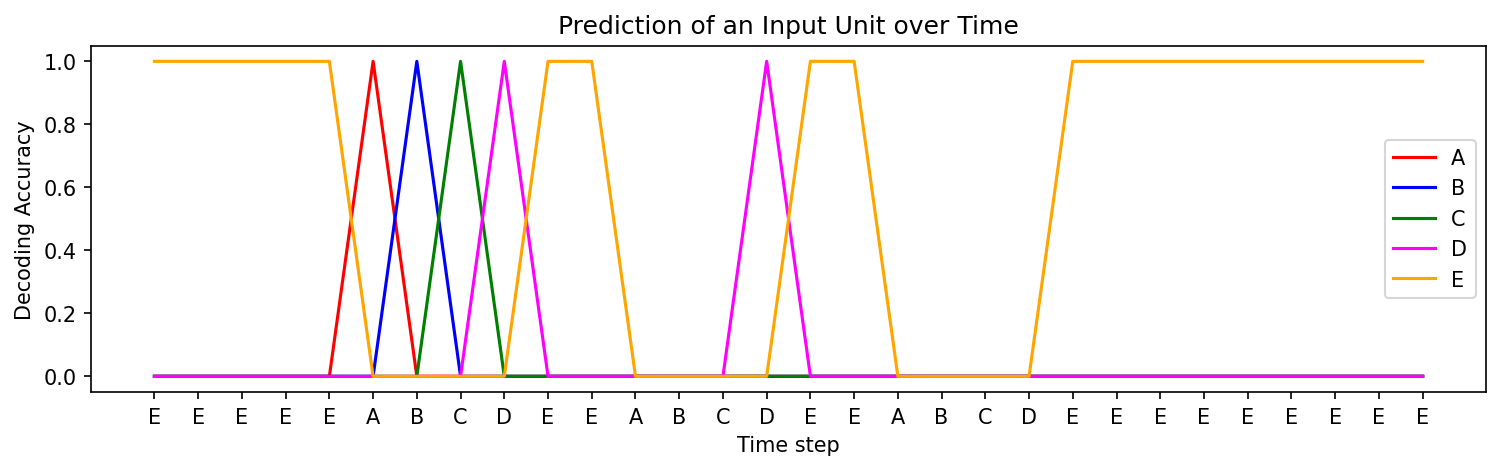

In [17]:
test_seq = hidden_seq[train_l:]
plt.figure(figsize=(12, 3), dpi = 150)
L = 30
plt.plot(np.arange(0,L,1), prediction_record['A'][0:L],color = 'red')
plt.plot(np.arange(0,L,1), prediction_record['B'][0:L], color = 'blue')
plt.plot(np.arange(0,L,1), prediction_record['C'][0:L],color = 'green')
plt.plot(np.arange(0,L,1), prediction_record['D'][0:L], color = 'magenta')
plt.plot(np.arange(0,L,1), prediction_record['E'][0:L], color = 'orange')

plt.xlabel('Time step')
plt.ylabel('Decoding Accuracy')
plt.legend(['A','B','C', 'D', 'E'])
plt.xticks(range(0, L),test_seq[0:L])
plt.title('Prediction of an Input Unit over Time')
plt.show()

In [18]:
from collections import Counter
# chunks of states, how to find them 
state_trajectory = []
for i in range(0,symbolic_hidden_activity.shape[1]):
    state = ''.join(str(num) for num in symbolic_hidden_activity[:,i])
    state_trajectory.append(state)
vocab = Counter(state_trajectory)

In [19]:
trajcopy =[tuple([item]) for item in state_trajectory]
n_new_chunks = 5 #  
n_iter = 6
freq_threshold = 10 # minimal occurrance frequency of token pair
for _ in range(0,n_iter):
    vocab = dict(Counter(trajcopy))
    paired_freq = Counter(zip(trajcopy[:-1], trajcopy[1:])).most_common(n_new_chunks)
    #for a,b in paired_freq:print(a,b)
    merged_list = [(char_tuple[0]+char_tuple[1], freq) for char_tuple, freq in paired_freq if freq >= freq_threshold]
    merged_dict = {}
    for key, value in merged_list:
        merged_dict[key] = value
    # add a mechanism that checks for overlaps amongst vocabs 
    vocab.update(merged_dict)
    vocab = chunkmerging(vocab,state_trajectory)
    trajcopy = parse_state_trajectory_1(state_trajectory, vocab)
    # print(len(trajcopy))

# Perturbation of state dynamics disrupts sequence prediction


In [20]:
# translator: from state string to cluster center:
transported_state = torch.tensor(state_transport(cluster_center_record,n_neurons = n_neurons,state_string= '221014241314'))

/tmp/ipykernel_33324/3304106825.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transported_state = torch.tensor(state_transport(cluster_center_record,n_neurons = n_neurons,state_string= '221014241314'))


## just do one step perturbation

In [21]:
input_char = 'A'
input_tensor = torch.nn.functional.one_hot(torch.tensor([char_to_int[input_char]], dtype=torch.long), num_classes=input_size).type(torch.float)
hidden_state = state_transport(cluster_center_record,n_neurons = n_neurons,state_string = generate_state_from_predictor(predictor,'B'))
output,_ = rnn(input_tensor, hidden_state) # hidden state correspond to when input is 'E'
# prediction before perturbation 
probabilities_before_perturbation = torch.exp(output)
predict_char = int_to_char[output.argmax(1).item()]
print('previous char ', input_char,' prediction char ', int_to_char[output.argmax(1).item()])

previous char  A  prediction char  D


### teleport hidden state to 'A', and send an input as 'B', then you get 'C'

In [22]:
####################### Perturbation: transport hidden states to B #####################
print(' Perturb hidden state to those that correspond to B ')
perturb_char = 'B'
perturb_tensor = torch.nn.functional.one_hot(torch.tensor([char_to_int[perturb_char]], dtype=torch.long), num_classes=input_size).type(torch.float)
perturbed_hidden_state = state_transport(cluster_center_record,n_neurons = n_neurons,state_string = generate_state_from_predictor(predictor,input_char))
output,_ = rnn(perturb_tensor, perturbed_hidden_state)
probabilities_after_perturbation = torch.exp(output)
predict_char = int_to_char[output.argmax(1).item()]
print('input char ', perturb_char,' prediction char ', int_to_char[output.argmax(1).item()])


 Perturb hidden state to those that correspond to B 
input char  B  prediction char  C


In [23]:
####################### Perturbation: transport hidden states to C #####################
print(' Perturb hidden state to those that correspond to B ')
input_char = 'B' # transport memory to state B
perturb_char = 'C'
perturb_tensor = torch.nn.functional.one_hot(torch.tensor([char_to_int[perturb_char]], dtype=torch.long), num_classes=input_size).type(torch.float)
perturbed_hidden_state = state_transport(cluster_center_record,n_neurons = n_neurons,state_string = generate_state_from_predictor(predictor,input_char))
output,_ = rnn(perturb_tensor, perturbed_hidden_state)
probabilities_after_perturbation = torch.exp(output)
predict_char = int_to_char[output.argmax(1).item()]
print('input char ', perturb_char,' prediction char ', int_to_char[output.argmax(1).item()])

 Perturb hidden state to those that correspond to B 
input char  C  prediction char  D


In [24]:
####################### Perturbation: transport hidden states to C #####################
print(' Perturb hidden state to those that correspond to B ')
input_char = 'C' # transport memory to state B
perturb_char = 'D'
perturb_tensor = torch.nn.functional.one_hot(torch.tensor([char_to_int[perturb_char]], dtype=torch.long), num_classes=input_size).type(torch.float)
perturbed_hidden_state = state_transport(cluster_center_record,n_neurons = n_neurons,state_string = generate_state_from_predictor(predictor,input_char))
output,_ = rnn(perturb_tensor, perturbed_hidden_state)
probabilities_after_perturbation = torch.exp(output)
predict_char = int_to_char[output.argmax(1).item()]
print('input char ', perturb_char,' prediction char ', int_to_char[output.argmax(1).item()])

 Perturb hidden state to those that correspond to B 
input char  D  prediction char  E


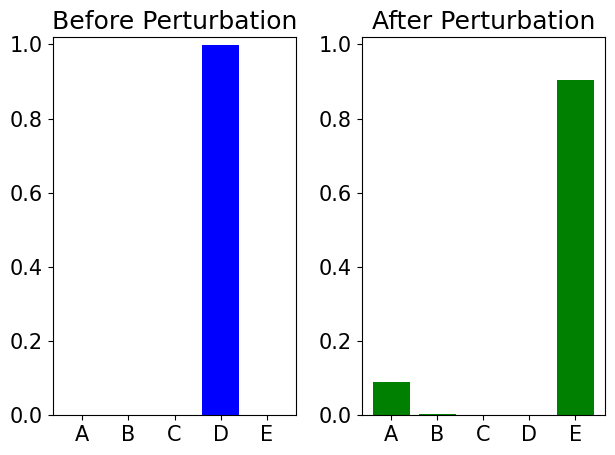

In [25]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 15})
# Sample data for the bar plots
categories = ['A', 'B', 'C', 'D', 'E']
values1 = probabilities_before_perturbation.detach().numpy()[0,:]
values2 = probabilities_after_perturbation.detach().numpy()[0,:]

fig, axs = plt.subplots(1, 2, dpi = 100)  # 1 row, 2 columns of figures figsize=(12, 5)

# Plotting the first bar plot
axs[0].bar(categories, values1, color='Blue')
axs[0].set_title('Before Perturbation')
axs[0].set_ylim(0, max(values1 + values2) + 0.02)  # Ensure both plots have the same y-axis scale

# Plotting the second bar plot
axs[1].bar(categories, values2, color='Green')
axs[1].set_title('After Perturbation')
axs[1].set_ylim(0, max(values1 + values2) + 0.02)  

plt.tight_layout()  # Adjusts subplot params to give some padding
plt.show()
